In [ ]:
# Load common utility functions from a separate Julia script
include("common_functions.jl")

# Import support for LaTeX-style strings for plotting and labeling
using LaTeXStrings

In [118]:
# Define a custom observer for DMRG convergence based on energy threshold and Lindbladian expectation
mutable struct DemoObserver <: AbstractObserver
    energy_tol::Float64               # Energy convergence threshold
    lind::MPO                         # Lindbladian operator for checking expectation value
    elist::Vector{ComplexF64}        # List of energies recorded at each sweep
    last_energy::ComplexF64          # Energy at previous sweep
    sweep_count::Int64               # Number of consecutive sweeps within threshold

    # Constructor
    DemoObserver(energy_tol, lind) = new(energy_tol, lind, ComplexF64[], -1.0, 0)
end

# Define the stopping criterion for DMRG sweeps
function ITensorMPS.checkdone!(o::DemoObserver; kwargs...)
    psi     = kwargs[:psi]           # Current MPS
    sw      = kwargs[:sweep]         # Current sweep number
    energy  = kwargs[:energy]        # Current energy

    # Optional: Uncomment to monitor true expectation value
    # println("True energy = ", inner(psi', o.lind, psi) / norm(psi)^2)

    # Track convergence: increase counter if energy change is below threshold
    if abs(energy - o.last_energy) < 1e-8
        o.sweep_count += 1
    else
        o.sweep_count = 0
    end

    # Check if convergence criteria are met
    if (abs(real(energy)) < o.energy_tol) || (o.sweep_count >= 4)
        println("Observer-based stopping DMRG after sweep $sw")
        return true
    end

    # Update observer state
    push!(o.elist, energy)
    o.last_energy = energy

    return false
end

### Function to generate the Lindbladian

In [120]:
"""
    get_lind(sites; coeff, pbc=false, bc_weak=false, bc_strong=false)

Construct the Lindbladian MPO given a set of coefficients and lattice geometry.

# Arguments
- `sites`: The site indices (e.g., from `siteinds("S=1/2", N)`).
- `coeff`: A list of coefficients controlling which terms are added (default includes standard L0/L1/L2).
- `pbc`: Periodic boundary conditions (currently unused).
- `bc_weak`, `bc_strong`: Flags for adding special boundary terms (unused here but placeholders for future use).

# Returns
- `lind`: The constructed Lindbladian as an MPO.
"""
function get_lind(sites; coeff = [1,0,0,0,0,0,1,1,0,0,0,0], pbc=false, bc_weak=false, bc_strong=false)
    # Unpack coefficients
    CL0, CL3, CLx_odd, CLx_even, CLz_odd, CLz_even,
    CL1, CL2, CL0_old, CLzz, CL0_left,
    CL0_dual, CL1_dual, CL2_dual, CL_pert = coeff

    N = length(sites) ÷ 2  # Assumes 2-site unit cells
    os = OpSum()

    ## Single-site Lindblad terms (even sites)
    for i in 2:2:N-1
        os += L0_minus(i, CL0)
        os += L0_dual(i, CL0_dual)
    end

    ## Single-site Lindblad terms (odd sites)
    for i in 1:2:N
        os += L1(i, CL1)
        os += L1_dual(i, CL1_dual)
    end

    ## L2 terms (paper-specific)
    for i in 3:2:N-1
        os += L2_paper(i, proj, CL2)
        os += L2_paper_dual(i, proj, CL2_dual)
    end

    # --------------------------------------------------------------------
    # Below are alternative/additional interaction terms you can enable
    # by uncommenting. Organized by category.
    # --------------------------------------------------------------------

    ## Two-site interaction terms
    # for i in 2:2:N-1
    #     os += L_two_site(i, pmp, pmp, CL_pert)
    # end

    ## Lzz or Lxx interactions
    # for i in 2:2:N-1
    #     os += Lzz(i, CL_pert)
    # end
    # for i in 1:N-1
    #     os += Lxx_consecutive(i, CL_pert)
    # end

    ## Local fields (optional)
    # for i in 1:2:N
    #     os += Hx(i, CL_pert)
    # end

    ## Hzz interactions
    # for i in 2:2:N-2
    #     os += Hzz(i, CL_pert)
    # end

    ## Generic two-site Hamiltonians
    # for i in 1:2:N-2
    #     os += H_two_site(i, CL_pert, Z, Z)
    # end

    ## Alternating projectors or Pauli strings
    # for i in 1:2:N-2
    #     os += L_two_site(i, p00, p01, CL_pert)
    #     os += L_two_site(i, p11, p10, CL_pert)
    # end

    ## Miscellaneous two-site Pauli terms
    # for i in 1:4:N-3
    #     os += L_two_site(i, Id, Z, 1.1 * CL_pert)
    #     os += L_two_site(i, Z, Id, 2.3 * CL_pert)
    #     os += L_two_site(i, X, X, 4.3 * CL_pert)
    #     os += L_two_site(i, X, Y, 1.3 * CL_pert)
    #     os += L_two_site(i, Y, X, 0.65 * CL_pert)
    #     os += L_two_site(i, Y, Y, 0.19 * CL_pert)
    #     os += L_two_site(i, Z, Z, 2.1 * CL_pert)
    # end

    ## Build the Lindbladian MPO
    lind = MPO(os, sites)

    println("Maximum bond dimension of Lindbladian = ", maximum(linkdims(lind)))
    return lind
end

get_lind

### Main DMRG function to determine steady state

In [121]:
"""
    main_lindbladian(N; λ=0.0, h=0.0)

Run DMRG to find the steady state of a Lindbladian with adjustable coupling (λ) and perturbation (h).

# Arguments
- `N`: Number of *unit cells* (physical sites = 2N).
- `λ`: Dual sector coupling (default = 0).
- `h`: Perturbation strength (default = 0).

# Returns
- `energy_list`: List of energies of steady states found.
- `state_list`: Corresponding MPS wavefunctions.
- `var_list`: Energy variances.
- `sites`: Site indices.
- `lind`: Lindbladian MPO.
"""
function main_lindbladian(N, λ = 0.0, h = 0.0)

    # -------------------------
    # DMRG and Lindbladian Setup
    # -------------------------
    nstates = 1                         # Number of steady states to find
    weight = 10                         # Weight parameter for DMRG
    energy_stop_tol = 3e-5              # Stopping tolerance for energy
    krylovdim = 20                      # Dimension of Krylov space
    nsweeps = 20                        # Number of DMRG sweeps
    maxdim = [10,30,50,100,100,100,100,200,200]  # Bond dimension schedule
    cutoff = [1e-12]                    # Truncation cutoff
    noise = [0.1, 0.01, 1e-6, 1e-7, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10, 1e-12]  # Noise schedule

    # -------------------------
    # Define Lindblad Coefficients
    # -------------------------
    CL0 = 1.0 - λ
    CL1 = 1.0 - λ
    CL2 = 1.0 - λ
    CL0_dual = λ
    CL1_dual = λ
    CL2_dual = λ
    CL_pert = h

    # Other coefficients (unused but included for compatibility)
    CL3 = CLx_odd = CLx_even = CLz_odd = CLz_even = 0.0
    CL0_old = CLzz = CL0_left = 0.0

    coeff = [CL0, CL3, CLx_odd, CLx_even, CLz_odd, CLz_even,
             CL1, CL2, CL0_old, CLzz, CL0_left,
             CL0_dual, CL1_dual, CL2_dual, CL_pert]

    println("N = $N")
    println("coeff = ", coeff)

    # -------------------------
    # Construct Lindbladian MPO
    # -------------------------
    sites = si(2N)
    lind = get_lind(sites, coeff)
    obs = [DemoObserver(energy_stop_tol, -lind) for _ in 1:nstates]

    # -------------------------
    # Main DMRG Loop
    # -------------------------
    state_list = []
    energy_list = []
    var_list = []

    for i in 1:nstates
        println("Running DMRG for state $i")
        initial_state::MPS = randomMPS(sites, 6)

        if !isempty(state_list)
            # With warm start
            energy, psi = dmrg(-lind, Vector{MPS}(state_list), initial_state;
                observer=obs[i], nsweeps, ishermitian=false,
                eigsolve_krylovdim=krylovdim, maxdim=maxdim,
                noise=noise, cutoff=cutoff, weight=weight)
        else
            # Cold start
            energy, psi = dmrg(-lind, initial_state;
                observer=obs[i], nsweeps, ishermitian=false,
                eigsolve_krylovdim=krylovdim, maxdim=maxdim,
                noise=noise, cutoff=cutoff)
        end

        # -------------------------
        # Projection (Optional)
        # -------------------------
        projection = false
        if projection
            projected_psi = project(psi)
            println("Projecting to subspace of size = ", length(projected_psi))

            for state in projected_psi
                en = inner(state', -lind, state)
                var = norm(apply(lind, state))^2 - abs(en)^2
                if imag(var) > 1e-10
                    println("Warning: Imaginary variance")
                end
                if real(var) < 0.0
                    println("Warning: Negative variance")
                end
                var = abs(var)
                push!(state_list, state)
                push!(energy_list, en)
                push!(var_list, var)
                print(var, ", ")
            end
        else
            # -------------------------
            # Save Single Unprojected State
            # -------------------------
            state = psi
            en = inner(state', -lind, state)
            var = norm(apply(lind, state))^2 - abs(en)^2

            if imag(var) > 1e-10
                println("Warning: Imaginary variance")
            end
            if real(var) < 0.0
                println("Warning: Negative variance")
            end

            push!(state_list, state)
            push!(energy_list, en)
            push!(var_list, abs(var))

            println("Saving MPS")
            filename = "./data/saved_MPS/paper_unprojected_lambda$(N), $(λ).h5"
            f = h5open(filename, "w")
            write(f, "psi", state)
            close(f)
        end
    end

    # -------------------------
    # Return results
    # -------------------------
    println("Final energy list: ", energy_list)
    return energy_list, state_list, var_list, sites, lind
end

main_lindbladian

In [122]:
# ----------------------------------------
# Parameter Sweep for Lindbladian DMRG
# ----------------------------------------

# Initialize containers for results
energy_super_list = []     # Energies from each run
state_super_list = []      # Corresponding MPS states
var_super_list   = []      # Variances
deg_super_list   = []      # Degeneracy (low-energy states)

λ_super_list     = []      # Track λ values used
N_super_list     = []      # Track N values used
pert_super_list  = []      # Track perturbation strengths

# ----------------------------------------
# Define parameter grids
# ----------------------------------------
Nlist    = [400]                   # List of system sizes
λlist    = 0.0:0.1:0.2            # Range of λ values (coupling strength)
pert     = 0.0                    # Perturbation strength
pert_list = [pert]               # You can expand this if needed

# ----------------------------------------
# Run over all combinations of parameters
# ----------------------------------------
for N in Nlist
    for λ in λlist
        println("\nRunning DMRG with λ = $λ, N = $N")

        # Call main DMRG routine
        energy_list, state_list, var_list, sites, lind = main_lindbladian(N, λ, pert)

        # Count number of nearly-zero energy eigenvalues (degeneracy)
        deg = sum(abs.(energy_list) .< 1e-5)
        push!(deg_super_list, deg)

        println("System size N = $N")
        println("Variances = ", var_list)

        # Store results
        push!(energy_super_list, energy_list)
        push!(state_super_list, state_list)
        push!(var_super_list, var_list)
        push!(λ_super_list, λ)
        push!(pert_super_list, pert)
        push!(N_super_list, N)

        # Optional: Save interim results to disk
        # save("./data/temp/super_run_data.jld", "energy_super_list", energy_super_list)
    end
end


Running DMRG with λ = 0.0, N = 400
N = 400
coeff = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Maximum bond dimension of Lindbladian = 7
Running DMRG for state 1
After sweep 1 energy=-0.0011818351146375846 + 0.0007016160182995235im  maxlinkdim=10 maxerr=5.26E-03 time=9.735
After sweep 2 energy=1.6275840766859033e-13 + 2.741819242052094e-16im  maxlinkdim=8 maxerr=2.05E-15 time=3.269
Observer-based stopping DMRG after sweep 2
Saving MPS
Final energy list: Any[1.732755635435014e-13 + 8.294737368328501e-16im]
System size N = 400
Variances = Any[4.93482617796573e-27]

Running DMRG with λ = 0.1, N = 400
N = 400
coeff = [0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.9, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0]
Maximum bond dimension of Lindbladian = 8
Running DMRG for state 1
After sweep 1 energy=-0.028587893429818993 - 0.0012168868391783565im  maxlinkdim=10 maxerr=2.59E-03 time=9.786
After sweep 2 energy=-1.8844755214446645e-5 - 2.342283252363198e-9im  maxlinkdim=30 maxerr=1

In [51]:
N = 400

state_list = []
strong_state_list = []

λlist = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
λlist = [0.0, 0.1]

for λ in λlist
    filename = "./data/saved_MPS/paper_unprojected_lambda"*string(N)*", "*string(λ)*".h5"
    read_state = load_state(filename);
    push!(state_list, read_state)
    # push!(strong_state_list, plusplus_project(read_state))
end

# String correlators

In [65]:
strong_state_list = [plusplus_project(state) for state in state_list];
;

In [91]:
# string_start_pt = 180+1
string_start_pt = 100+1
string_end_pt = string_start_pt + 60 # Nlist[1] - 80-1

start_pt = string_start_pt
end_pt = string_end_pt # Nlist[1] - 160-1

# start_pt = 20+1
# end_pt = Nlist[1] - 40-1

y1_strong_nontrivial = []
y1_strong_trivial = []

y2_strong_nontrivial = []
y2_strong_trivial = []

y2_weak_nontrivial = []
y2_weak_trivial = []

xlist = []

for i in 1:length(strong_state_list)
    state = strong_state_list[i]
    s1_strong_nontrivial = []
    s1_strong_trivial = []
    
    s2_strong_nontrivial = []
    s2_strong_trivial = []
    
    s2_weak_nontrivial = []
    s2_weak_trivial = []
    
    x = []
     
    s = siteinds(state)
    ψ = get_ψid(s)
    den = inner(ψ,state)
    if abs(den) < 1e-5
        println("trace is very small")
    end

    for m in start_pt:4:end_pt    
        temp1 = strong_nontrivial_1copy_correlator(state, start_pt, m, den)
        temp3 = strong_nontrivial_2copy_correlator(state, start_pt, m, true)
        temp5 = weak_nontrivial_2copy_correlator(state, start_pt+1, m+1, true)
        push!(s1_strong_nontrivial, temp1)
        push!(s2_strong_nontrivial, temp3)
        push!(s2_weak_nontrivial, temp5)

        temp2 = strong_trivial_1copy_correlator(state, start_pt, m, den)
        temp4 = strong_trivial_2copy_correlator(state, start_pt, m, true)
        temp6 = weak_trivial_2copy_correlator(state, start_pt+1, m+1, true)
        push!(s1_strong_trivial, temp2)
        push!(s2_strong_trivial, temp4)
        push!(s2_weak_trivial, temp6)

        push!(x, m-start_pt)
    end
    push!(y1_strong_nontrivial, s1_strong_nontrivial)
    push!(y2_strong_nontrivial, s2_strong_nontrivial)
    push!(y2_weak_nontrivial, s2_weak_nontrivial)

    push!(y1_strong_trivial, s1_strong_trivial)
    push!(y2_strong_trivial, s2_strong_trivial)
    push!(y2_weak_trivial, s2_weak_trivial)

    push!(xlist, x)
    println("done")
end


done
done


In [67]:
# # conn_corrs = [distance, ZZ1, ZZ2, ZZZZ, start_pt,end_pt]
# # string_data = [xlist,y1_strong_nontrivial,  y2_strong_nontrivial, y2_weak_nontrivial,string_start_pt,  string_end_pt, Nlist[1]]
# # data_to_save = [string_data, conn_corrs, lbl_list]
# string_data, conn_corrs, lbl_list = load("./data/plot_data/other_pert_data.jld")["data_to_save"]
# xlist, y1_strong_nontrivial,  y2_strong_nontrivial, y2_weak_nontrivial, string_start_pt, string_end_pt, Nlist[1] = string_data

In [ ]:
markers = filter((m->begin
                m in Plots.supported_markers()
            end), Plots._shape_keys)
default(xformatter=:latex, yformatter=:latex,  left_margin=1Plots.mm, legend= :right, framestyle = :box, size=1.6 .* (350,250), xminorticks=4,yminorticks=4, xticks=3, yticks =4, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=10)
mshapes = [:circle, :rect, :pentagon, :xcross, :diamond, :cross,  :star5, :rtriangle, :star4]
mshapes = [:circle, :rect, :pentagon, :xcross, :diamond,  :star5,:star4, :rtriangle, :cross ]
mshapes =  [:circle, :rect, :star5, :diamond, :hexagon, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x];

;

In [81]:
function annotatewithbox!(
    fig::Plots.Plot,
    text::Plots.PlotText,
    x::Real, y::Real, Δx::Real, Δy::Real = Δx;
    kwargs...)

box = Plots.Shape(:rect)

Plots.scale!(box, Δx, Δy)
Plots.translate!(box, x, y)

Plots.plot!(fig, box, c = :white, linestroke = :black, label = false; kwargs...)
Plots.annotate!(fig, x, y, text)

fig
end

annotatewithbox! (generic function with 2 methods)

In [82]:
clrs = [1, 9, 8, 4, 5, 6, 14, 1, 7]
plet =palette(:auto)[clrs] 
palette(:auto)[clrs]

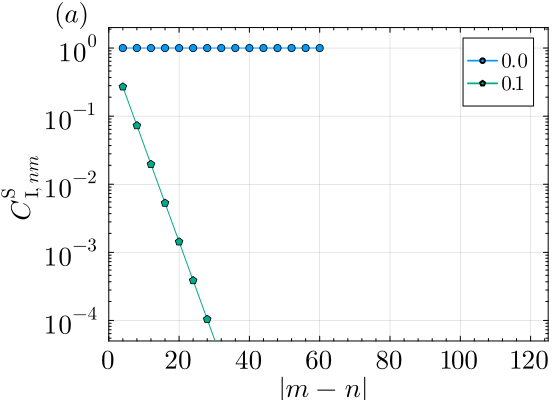

In [ ]:
ylbl = "\$   C_{\\textrm{I}, nm}^{\\textrm{S}}  \$"
xlbl = "\$|m-n|\$"
# xticks = [0,10, 20,30, 40,50, 60]
# yticks = [-10,-8, -6, -4, -2, 0]
# scalefontsizes(1/1.3)
p1 = plot( top_margin=5Plots.mm,bottom_margin=-.6Plots.mm,left_margin=1.1Plots.mm,right_margin=1.0Plots.mm, xlabel=xlbl, ylabel=ylbl,xformatter=:latex, yformatter=:latex, yaxis=:log, legend= :topright, framestyle = :box, xminorticks=5, 
        xticks= 2 .* [0,10, 20, 30, 40,50,  60], yticks =[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],yminorticks =10, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=14)
mshapes = [:circle, :pentagon, :rect, :star4, :diamond,  :star5, :xcross, :rtriangle , :cross]

# for i in 1:length(strong_state_list)
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p1,xlist[i][2:end], (abs.(y1_strong_nontrivial[i]))[2:end], label=lbl, markershape=mshapes[i],c=plet[i])
end
# annotatewithbox!(p1, text(L"(a)"), 50, 0.5, 1, 3)
annotate!(-10, 3, text(L"(a)", 18), :black)
# annotate!(57, 0.4, L"(a)", :black)
plot!( ylim=(5e-5,2), xlim = (0,125))
# savefig(p1,"./images/for_paper/cs1_other_pert1.pdf")
display(p1)

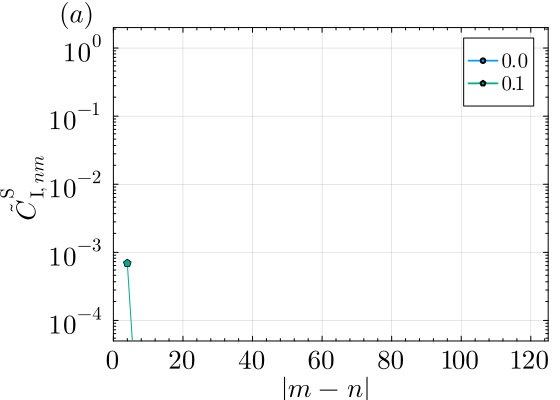

In [94]:
ylbl = "\$   \\tilde{C}_{\\textrm{I}, nm}^{\\textrm{S}}  \$"
xlbl = "\$|m-n|\$"
# xticks = [0,10, 20,30, 40,50, 60]
# yticks = [-10,-8, -6, -4, -2, 0]
# scalefontsizes(1/1.3)
p1 = plot( top_margin=5Plots.mm,bottom_margin=-.6Plots.mm,left_margin=1.1Plots.mm,right_margin=1.0Plots.mm, xlabel=xlbl, ylabel=ylbl,xformatter=:latex, yformatter=:latex, yaxis=:log, legend= :topright, framestyle = :box, xminorticks=5, 
        xticks= 2 .* [0,10, 20, 30, 40,50,  60], yticks =[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],yminorticks =10, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=14)
mshapes = [:circle, :pentagon, :rect, :star4, :diamond,  :star5, :xcross, :rtriangle , :cross]

# for i in 1:length(strong_state_list)
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p1,xlist[i][2:end], (abs.(y1_strong_trivial[i]))[2:end], label=lbl, markershape=mshapes[i],c=plet[i])
end
# annotatewithbox!(p1, text(L"(a)"), 50, 0.5, 1, 3)
annotate!(-10, 3, text(L"(a)", 18), :black)
# annotate!(57, 0.4, L"(a)", :black)
plot!( ylim=(5e-5,2), xlim = (0,125))
# savefig(p1,"./images/for_paper/cs1_other_pert1.pdf")
display(p1)

In [95]:
# ylbl = "\$   C_{\\textrm{I}, nm}^{\\textrm{S}}  \$"
# xlbl = "\$|m-n|\$"
# # xticks = [0,10, 20,30, 40,50, 60]
# # yticks = [-10,-8, -6, -4, -2, 0]
# p2 = plot( top_margin=5Plots.mm,bottom_margin=-.6Plots.mm,left_margin=1.1Plots.mm,right_margin=2.5Plots.mm,xlabel=xlbl, ylabel=ylbl, xformatter=:latex, yformatter=:latex, yaxis=:log, xlim=(0,125), ylim=(1e-4, 2),  legend= :topright, framestyle = :box, xminorticks=5, 
#         xticks= 2 .* [0,10, 20, 30, 40,50,  60], yticks =[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],yminorticks =10, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=14)
# mshapes = [:circle, :pentagon, :rect, :star4, :diamond,  :star5, :xcross, :rtriangle , :cross]

# for i in 1:length(strong_state_list)
#     lbl = lbls[i]
#     plot!(p2,xlist[i][2:end], (abs.(y1_strong_nontrivial[i]))[2:end], label = lbl, markershape=mshapes[i], c=plet[i])
# end
# # annotate!(57, 0.4, L"(b)", :black)
# annotate!(-10, 3, text(L"(a)", 18), :black)
# # savefig(p2,"./images/for_paper/cs1_other_pert.pdf")
# display(p2)

In [96]:
clrs = [1, 9, 8, 4, 5, 6, 14, 1, 7]
clrs = [1, 2, 13, 4, 5, 6, 7, 9, 12, 10, 11, 12, 13, 14]
plet =palette(:auto)[clrs] 
palette(:auto)[clrs]

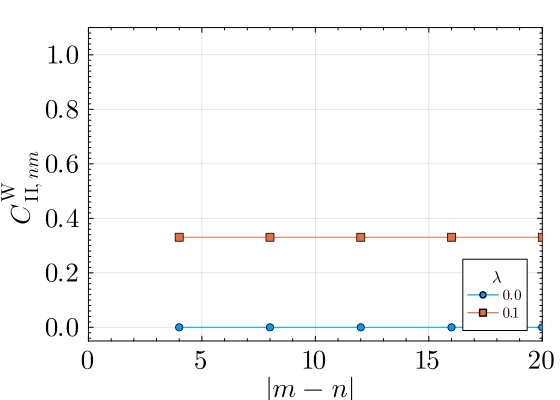

In [102]:
ylbl = "\$   C_{\\textrm{II}, nm}^{\\textrm{W}}  \$"
xlbl = "\$|m-n|\$"

p2 = plot( top_margin=5Plots.mm,bottom_margin=-.6Plots.mm,left_margin=1.1Plots.mm,right_margin=2.5Plots.mm,xlabel=xlbl, ylabel=ylbl, legendtitle =L"\lambda", xformatter=:latex, yformatter=:latex,    legend= :bottomright, framestyle = :box, xminorticks=5, 
        xticks= [0,5, 10, 15, 20], yticks =[0.0,0.2,0.4,0.6,0.8,1.0],yminorticks =10, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=10)
mshapes = [:circle, :pentagon, :rect, :star4, :diamond,  :star5, :xcross, :rtriangle , :cross]
mshapes = [:circle, :rect, :pentagon, :xcross, :diamond,  :cross, :star5, :rtriangle , :star4]

for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p2,xlist[i][2:end], (abs.(y2_weak_trivial[i]))[2:end], label = lbl, markershape=mshapes[i], c=plet[i])
end
# annotate!(57, 0.4, L"(b)", :black)
plot!(ylim = (-0.05,1.1), xlim=(0,20))
annotate!(-10, 1.035, text(L"(c)", 18), :black)
# savefig(p2,"./images/for_paper/cw2_other_pert.pdf")
display(p2)

# Connected correlators

In [104]:
start_pt = 90
# start_pt = 140
end_pt = start_pt + 20 # Nlist[1] - start_pt+2

distance = []
ZZ1 = []
ZZ2 = []
ZZZZ = []
for j in 1:length(strong_state_list)
    psi = strong_state_list[j]

    datazz1 = []
    datazz2 = []
    datazzzz = []

    dist = []
    for i in start_pt:2:end_pt
        push!(datazz1, ZZ_corr_1copy(psi, start_pt, i, Z))
        push!(datazz2, ZZ_corr(psi, start_pt, i, Z))
        push!(datazzzz, ZZZZ_corr(psi, start_pt, i))
        push!(dist, abs(i-start_pt))
    end
    push!(distance, dist)
    push!(ZZ1, datazz1)
    push!(ZZ2, datazz2)
    push!(ZZZZ, datazzzz)
    println("done")
end

done
done


In [105]:
# dmrg_params = [Nlist, λlist]
# string_correlators = [xlist, y1_strong_nontrivial, y1_strong_trivial, y2_strong_nontrivial, y2_strong_trivial, y2_weak_nontrivial, y2_weak_trivial, string_start_pt, string_end_pt]
conn_corrs = [distance, ZZ1, ZZ2, ZZZZ, start_pt,end_pt]

string_data = [xlist,y1_strong_nontrivial,  y2_strong_nontrivial, y2_weak_nontrivial,string_start_pt,  string_end_pt, Nlist[1]]
data_to_save = [string_data, conn_corrs, lbl_list]
# save("./data/plot_data/other_pert_data.jld", "data_to_save",data_to_save)
# data_to_save = [dmrg_params, string_correlators, conn_corrs]
# save("./data/plot_data/other_pert_conn_corr.jld", "data_to_save", data_to_save)


3-element Vector{Vector{Any}}:
 [Any[Any[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60], Any[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]], Any[Any[7.840316633898178e-15 + 6.121353160030436e-15im, 0.9999999999999704 + 4.3460109305560685e-15im, 0.9999999999999669 + 8.692021861112137e-15im, 0.9999999999999443 + 1.3121609924948129e-14im, 0.9999999999999231 + 1.6464695256145105e-14im, 0.9999999999999254 + 1.997493485390193e-14im, 0.9999999999999306 + 2.1897208919340188e-14im, 0.9999999999999172 + 2.691183691613565e-14im, 0.9999999999999049 + 3.159215637981142e-14im, 0.9999999999999046 + 3.543670451068794e-14im, 0.999999999999897 + 3.994986970780386e-14im, 0.999999999999901 + 4.4797343438039473e-14im, 0.9999999999998916 + 4.83075830357963e-14im, 0.9999999999998817 + 5.0814897034194024e-14im, 0.9999999999998666 + 5.0062702834674706e-14im, 0.9999999999998651 + 5.3238633899311834e-14im], Any[1.7036778978780697e-12 - 2.0777972396500245e-11im, 0.2698738643395418 - 5

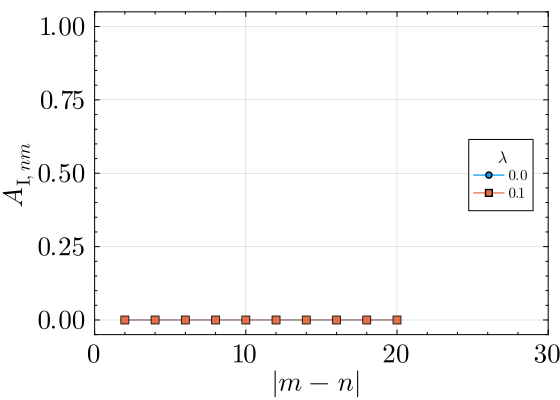

In [109]:
ylbl = "\$ A_{\\textrm{I}, nm} \$"
xlbl = "\$|m-n|\$"
# yticks = 
p = plot( xlabel=xlbl, ylabel=ylbl, xformatter=:latex,  legendtitle ="\$\\lambda\$",yformatter=:latex,ylim = (-0.05,1.05),xlim=(0,30),  legend= :right, framestyle = :box, xminorticks=5, xticks=[0,10,20,30,40], yticks =[0,0.25,0.5,0.75,1.0],yminorticks =5, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=10)
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p,distance[i][2:end], abs.(ZZ1[i])[2:end], label = lbl, markershape=mshapes[i])
end
# savefig(p,"./images/for_paper/a1.pdf")
display(p)

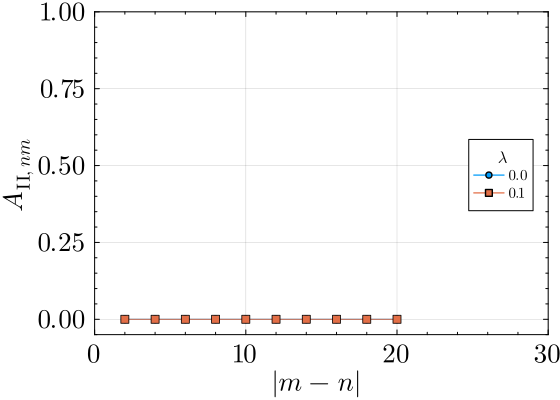

In [111]:
ylbl = "\$ A_{\\textrm{II}, nm} \$"
xlbl = "\$|m-n|\$"
yticks = [0,0.25,0.5,0.75,1.0]
# xticks = 
p = plot( xlabel=xlbl, ylabel=ylbl, xformatter=:latex,  legendtitle ="\$\\lambda\$",yformatter=:latex,ylim = (-0.05,1),xlim=(0,30),  legend= :right, framestyle = :box, xminorticks=5, xticks=[0,10,20,30,40], yticks =yticks,yminorticks =5, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=10)
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p,abs.(distance[i])[2:end], (abs.(ZZ2[i]))[2:end], label = lbl, markershape=mshapes[i])
end
# savefig(p,"./images/for_paper/a2_1.pdf")
display(p)

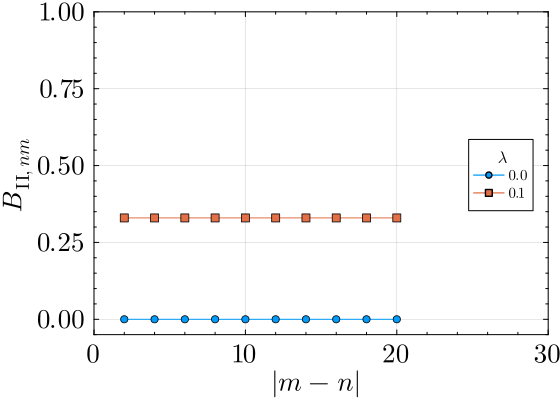

In [112]:
ylbl = "\$ B_{\\textrm{II}, nm} \$"
xlbl = "\$|m-n|\$"
yticks = [0,0.25,0.5,0.75,1.0]
# xticks = 
p = plot( xlabel=xlbl, ylabel=ylbl, xformatter=:latex,  legendtitle ="\$\\lambda\$",yformatter=:latex,ylim = (-0.05,1),xlim=(0,30),  legend= :right, framestyle = :box, xminorticks=5, xticks=[0,10,20,30,40], yticks =yticks,yminorticks =5, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18,legendfontsize=10)
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(p,abs.(distance[i])[2:end], (abs.(ZZZZ[i]))[2:end], label = lbl, markershape=mshapes[i])
end
# savefig(p,"./images/for_paper/a2_1.pdf")
display(p)